In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import time
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from matplotlib.colors import LogNorm
from scipy.signal import convolve as scipy_convolve

In [8]:
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']  # central wavelength. CDELT3 is microns per pixel. 
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
#[central_x,central_y]= [57,57]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

#hdu.info()
#print(qso_header)  # Bunit = '10**(-20)*erg/s/cm**2/Angstrom', is the factor multiplied by the ydata

In [3]:
mini_cube = qso_data[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
mini_cube_error = qso_error[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 22)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 22)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavestart,(wavestart+(wavint*mini_cube.shape[0])),wavint)

In [4]:
z =0.02172 
k = 1+z
c = 300000
central_vel = c*z
wave = wave
mini_data = qso_data
mini_error = np.sqrt(qso_error)
#mini_data = mini_cube
#mini_error = mini_cube_error

In [5]:
select = (wave > 6400*k) & (wave < 6800*k)
select2 = (wave > 6552*k) & (wave < 6572*k) 
select3 = (wave > 6750*k) & (wave < 6780*k)
par = np.zeros((14,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((14,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [6]:
def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Ha_gauss(wave,amp_Ha,vel,vel_sigma):
    Ha = gauss(wave,amp_Ha,vel,vel_sigma,6562.85)
    return Ha

def NII_doublet_gauss(wave,amp_N6583,vel,vel_sigma):
    N_6548 = 0.33*gauss(wave,amp_N6583,vel,vel_sigma,6548.05)
    N_6583 = gauss(wave,amp_N6583,vel,vel_sigma,6583.45)
    return N_6548+N_6583

def SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel,vel_sigma):
    S_6716 = gauss(wave,amp_S6716,vel,vel_sigma,6716.44)
    S_6731 = gauss(wave,amp_S6731,vel,vel_sigma,6731.82)
    return S_6716+S_6731

def full_gauss(p,wave,data,error):    
    (amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,vel_core,vel_core_sigma,vel_wing, vel_wing_sigma,m,c) = p 
    narrow_Ha = Ha_gauss(wave,amp_Ha,vel_core,vel_core_sigma)
    broad_Ha = Ha_gauss(wave,amp_Ha_br,vel_wing,vel_wing_sigma)
    narrow_NII = NII_doublet_gauss(wave,amp_N6583,vel_core,vel_core_sigma)
    broad_NII = NII_doublet_gauss(wave,amp_N6583_br,vel_wing,vel_wing_sigma)
    narrow_SII = SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel_core,vel_core_sigma)
    broad_SII = SII_doublet_gauss(wave,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma)
    cont = (wave/1000.0)*m+c
    return (narrow_Ha+broad_Ha+narrow_NII+broad_NII+narrow_SII+broad_SII+cont-data)/error

In [7]:
start = time.time()

for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        y = mini_data[:,i,j][select]
        y_err = mini_error[:,i,j][select]
        x = wave[select]    
        
        emissData = mini_data[:,i,j][select2]
        contData = mini_data[:,i,j][select3]
        
        meanFlux = np.mean(emissData)
        noise = np.std(contData)
        
        SN = meanFlux/noise
        #print(SN)

        lower_bounds = [0,0,0,0,0,0,0,0,central_vel - 1000,0,central_vel - 1000,0,-np.inf,-np.inf]
        upper_bounds = [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,central_vel + 1000,300,central_vel + 1000,1000,np.inf,np.inf]
        bounds_p_init = (lower_bounds,upper_bounds) 
        
        #popt1,pcov1 = leastsq(full_gauss,x0=[850,80,856,640,195,87,176,140,6,103,11,340,-3,18],args = (x,y,y_err),maxfev=10000000)
              
#         try:
#             result = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],bounds=bounds_p_init,args = (x,y,y_err),max_nfev=10000000)
#             popt1 = result['x']  
            
#         except RuntimeError or RuntimeWarning:
#             popt1 = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,central_vel,1e-5,0.0001,0.01]
            
        if SN >= 1:
            result = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],bounds=bounds_p_init,args = (x,y,y_err),max_nfev=10000000)
            popt1 = result['x']
        else:
            popt1 = [1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,central_vel,0,central_vel,0,0.0001,0.01]
        
        par[:,i,j] = popt1
        
        model = full_gauss(popt1,x,y,y_err)*(y_err)+y
        fitted[:,i,j] = model
        
        #plt.plot(x,y)
        #plt.plot(x,model)
        #plt.show()
        
        residuals[:,i,j] = mini_data[:,i,j][select] - fitted[:,i,j]

        Monte_Carlo_loops = 100  # larger the sample size, more accurate it is. 
        parameters_MC = np.zeros((len(popt1),Monte_Carlo_loops))  # for each loop, we have the fit parameters. 
        
        for l in range(Monte_Carlo_loops):  # simulation to estimate error in spectrum. Fluctuate the data with noise. Parameters should not vary, if does, not accutae. 
            iteration_data = np.random.normal(y,y_err)  # fluctuations to create gaussian distribution of parameters. std can be used to find error. 
            if SN >= 1:
                result_MC = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],bounds=bounds_p_init,args = (x,iteration_data,y_err),max_nfev=10000000)
                popt_MC = result_MC['x']
            else:
                popt_MC = [1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,central_vel,0,central_vel,0,0.0001,0.01]
#             try:
#                 result_MC = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],args = (x,iteration_data,y_err),max_nfev=10000000)
#                 popt_MC = result_MC['x']
#             except RuntimeError or RuntimeWarning:
#                 popt_MC = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,central_vel,1e-5,0.0001,0.01]
            parameters_MC[:,l]=popt_MC
            
        parameters_err = np.nanstd(parameters_MC,1)
        err[:,i,j]=parameters_err
        

print("Time elapsed: ", str(time.time() - start))

Time elapsed:  5552.052725315094


In [8]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(par[0,:,:],name='amp_Ha'))
hdus.append(fits.ImageHDU(par[1,:,:],name='amp_Ha_br'))
hdus.append(fits.ImageHDU(par[2,:,:],name='amp_N6583'))
hdus.append(fits.ImageHDU(par[3,:,:],name='amp_N6583_br'))
hdus.append(fits.ImageHDU(par[4,:,:],name='amp_S6716'))
hdus.append(fits.ImageHDU(par[5,:,:],name='amp_S6716_br'))
hdus.append(fits.ImageHDU(par[6,:,:],name='amp_S6731'))
hdus.append(fits.ImageHDU(par[7,:,:],name='amp_S6731_br'))
hdus.append(fits.ImageHDU(par[8,:,:],name='vel_core'))
hdus.append(fits.ImageHDU(par[9,:,:],name='vel_core_sigma'))
hdus.append(fits.ImageHDU(par[10,:,:],name='vel_wing'))
hdus.append(fits.ImageHDU(par[11,:,:],name='vel_wing_sigma'))
hdus.append(fits.ImageHDU(par[12,:,:],name='m'))
hdus.append(fits.ImageHDU(par[13,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_LSQ_121x121_SN.fits',overwrite=True)

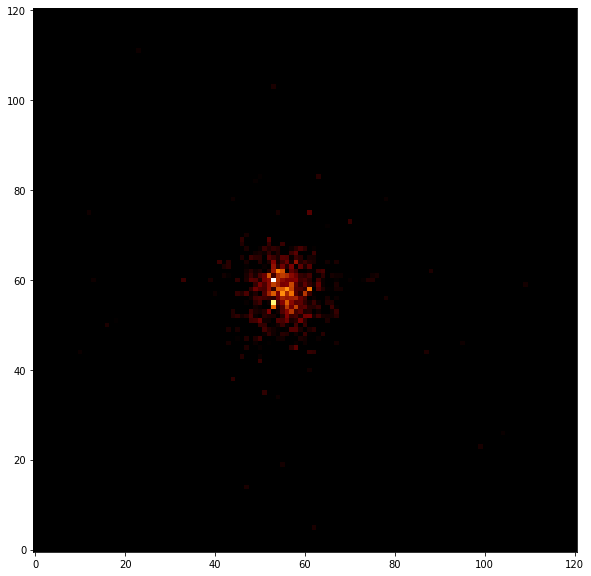

In [9]:
with fits.open('subcube_par_3C264_LSQ_121x121_SN.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Ha = hdu[1].data
    Ha_br = hdu[2].data
    N6583 = hdu[3].data
    N6583_br = hdu[4].data
    S6716 = hdu[5].data
    S6716_br = hdu[6].data
    S6731 = hdu[7].data
    S6731_br = hdu[8].data
    vel_core = hdu[9].data
    vel_core_sigma = hdu[10].data
    vel_wing = hdu[11].data
    vel_wing_sigma = hdu[12].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Ha_br,cmap='afmhot',origin='lower')

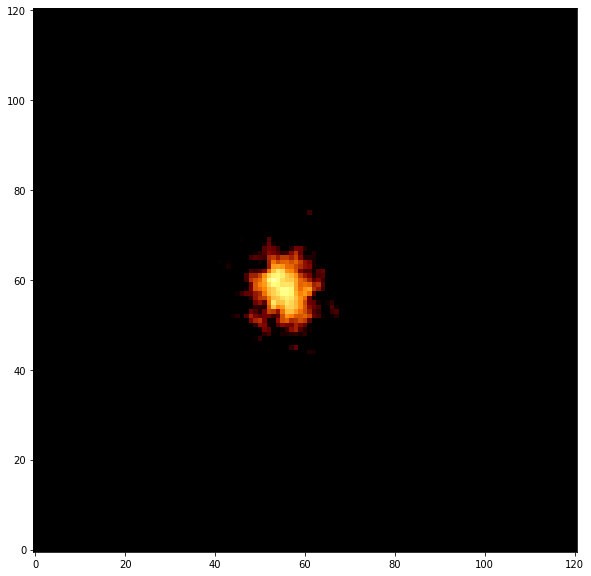

In [10]:
fig=plt.figure(figsize=(10,10))
kernel = Gaussian2DKernel(0.75)
smoothed_data_gauss = convolve(Ha_br, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=10,vmax=250,norm=LogNorm())

In [11]:
(y0,x0) = ndimage.measurements.maximum_position(Ha)
print(y0,x0)

# QFitsView says: Image X = 55.672 and Image Y = 57.678

57 53


In [12]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(err[0,:,:],name='amp_Ha_err'))
hdus.append(fits.ImageHDU(err[1,:,:],name='amp_Ha_br_err'))
hdus.append(fits.ImageHDU(err[2,:,:],name='amp_N6583_err'))
hdus.append(fits.ImageHDU(err[3,:,:],name='amp_N6583_br_err'))
hdus.append(fits.ImageHDU(err[4,:,:],name='amp_S6716_err'))
hdus.append(fits.ImageHDU(err[5,:,:],name='amp_S6716_br_err'))
hdus.append(fits.ImageHDU(err[6,:,:],name='amp_S6731_err'))
hdus.append(fits.ImageHDU(err[7,:,:],name='amp_S6731_br_err'))
hdus.append(fits.ImageHDU(err[8,:,:],name='vel_core_err'))
hdus.append(fits.ImageHDU(err[9,:,:],name='vel_core_sigma_err'))
hdus.append(fits.ImageHDU(err[10,:,:],name='vel_wing_err'))
hdus.append(fits.ImageHDU(err[11,:,:],name='vel_wing_sigma_err'))
hdus.append(fits.ImageHDU(err[12,:,:],name='m_err'))
hdus.append(fits.ImageHDU(err[13,:,:],name='c_err'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_err_LSQ_121x121_SN_100loops.fits',overwrite=True)

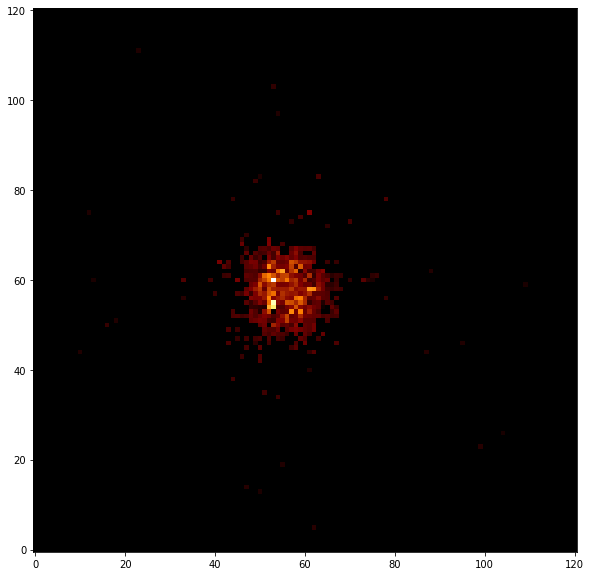

In [13]:
with fits.open('subcube_par_3C264_err_LSQ_121x121_SN_100loops.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Ha = hdu[1].data
    Ha_br = hdu[2].data
    N6583 = hdu[3].data
    N6583_br = hdu[4].data
    S6716 = hdu[5].data
    S6716_br = hdu[6].data
    S6731 = hdu[7].data
    S6731_br = hdu[8].data
    vel_core = hdu[9].data
    vel_core_sigma = hdu[10].data
    vel_wing = hdu[11].data
    vel_wing_sigma = hdu[12].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Ha_br,cmap='afmhot',origin='lower')

#similar shape to the flux maps, so our analysis was accurate. should look similar but with less SN ratio. fluctuations would be 
#more random. 

In [14]:
amp_Ha = par[0,:,:].ravel()
amp_Ha_br = par[1,:,:].ravel()
amp_N6583 = par[2,:,:].ravel()
amp_N6583_br = par[3,:,:].ravel()
amp_S6716 = par[4,:,:].ravel()
amp_S6716_br = par[5,:,:].ravel()
amp_S6731 = par[6,:,:].ravel()
amp_S6731_br = par[7,:,:].ravel()
vel_core = par[8,:,:].ravel()
vel_core_sigma = par[9,:,:].ravel()
vel_wing = par[10,:,:].ravel()
vel_wing_sigma = par[11,:,:].ravel()
m = par[12,:,:].ravel()
c = par[13,:,:].ravel()

amp_Ha_err = err[0,:,:].ravel()
amp_Ha_br_err = err[1,:,:].ravel()
amp_N6583_err = err[2,:,:].ravel()
amp_N6583_br_err = err[3,:,:].ravel()
amp_S6716_err = err[4,:,:].ravel()
amp_S6716_br_err = err[5,:,:].ravel()
amp_S6731_err = err[6,:,:].ravel()
amp_S6731_br_err = err[7,:,:].ravel()
vel_core_err = err[8,:,:].ravel()
vel_core_sigma_err = err[9,:,:].ravel()
vel_wing_err = err[10,:,:].ravel()
vel_wing_sigma_err = err[11,:,:].ravel()
m_err = err[12,:,:].ravel()
c_err = err[13,:,:].ravel()

In [15]:
c3 = fits.Column(name='amp_Ha', array=amp_Ha, format='E')
c4 = fits.Column(name='amp_Ha_err', array=amp_Ha_err, format='E')
c5 = fits.Column(name='amp_Ha_br', array=amp_Ha_br, format='E')
c6 = fits.Column(name='amp_Ha_br_err', array=amp_Ha_br_err, format='E')
c7 = fits.Column(name='amp_N6583', array=amp_N6583, format='E')
c8 = fits.Column(name='amp_N6583_err', array=amp_N6583_err, format='E')
c9 = fits.Column(name='amp_N6583_br', array=amp_N6583_br, format='E')
c10 = fits.Column(name='amp_N6583_br_err', array=amp_N6583_br_err, format='E')
c11 = fits.Column(name='amp_S6716', array=amp_S6716, format='E')
c12 = fits.Column(name='amp_S6716_err', array=amp_S6716_err, format='E')
c13 = fits.Column(name='amp_S6716_br', array=amp_S6716_br, format='E')
c14 = fits.Column(name='amp_S6716_br_err', array=amp_S6716_br_err, format='E')
c15 = fits.Column(name='amp_S6731', array=amp_S6731, format='E')
c16 = fits.Column(name='amp_S6731_err', array=amp_S6731_err, format='E')
c17 = fits.Column(name='amp_S6731_br', array=amp_S6731_br, format='E')
c18 = fits.Column(name='amp_S6731_br_err', array=amp_S6731_br_err, format='E')
c19 = fits.Column(name='vel_core', array=vel_core, format='E')
c20 = fits.Column(name='vel_core_err', array=vel_core_err, format='E')
c21 = fits.Column(name='vel_core_sigma', array=vel_core_sigma, format='E')
c22 = fits.Column(name='vel_core_sigma_err', array=vel_core_sigma_err, format='E')
c23 = fits.Column(name='vel_wing', array=vel_wing, format='E')
c24 = fits.Column(name='vel_wing_err', array=vel_wing_err, format='E')
c25 = fits.Column(name='vel_wing_sigma', array=vel_wing_sigma, format='E')
c26 = fits.Column(name='vel_wing_sigma_err', array=vel_wing_sigma_err, format='E')
c27 = fits.Column(name='m', array=m, format='E')
c28 = fits.Column(name='m_err', array=m_err, format='E')
c29 = fits.Column(name='c', array=c, format='E')
c30 = fits.Column(name='c_err', array=c_err, format='E')

t = fits.BinTableHDU.from_columns([c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22,c23,c24,c25,c26,c27,c28,c29,c30])

t.writeto('table_3C264_extended_double_gauss.fits',overwrite=True)

In [12]:
#hdu.open=('subcube_par_HE0232-0900_LSQ2.fits')
#Hb_blr = hdu[5].data
#OIII_nr = hdu[2].data
#OIII_br = hdu[3].data
#hdu.close()
#Hb_blr_centroid = ndimage.measurements.center_of_mass(Hb_blr)
#OIII_nr_centroid = ndimage.measurements.center_of_mass(OIII_nr)
#OIII_br_centroid = ndimage.measurements.center_of_mass(OIII_br)
#print('Centroid of Hb_blr is: ',Hb_blr_centroid)
#print('Centroid of OIII_nr is: ',OIII_nr_centroid)
#print('Centroid of OIII_br is: ',OIII_br_centroid)

In [13]:
#outflow_size_pix = np.sqrt((OIII_br_centroid[0] -  Hb_blr_centroid[0])**2 + (OIII_br_centroid[1] -  Hb_blr_centroid[1])**2)
#outflow_size_arc = 0.4*outflow_size_pix   
#print(outflow_size_arc)

In [14]:
#need distance to galaxy to find distance in parsec
#distance = 175.5
#outflow_size_parsec = (distance*outflow_size_arc)*4.848
#print(outflow_size_parsec) 
#Check MOFFAT

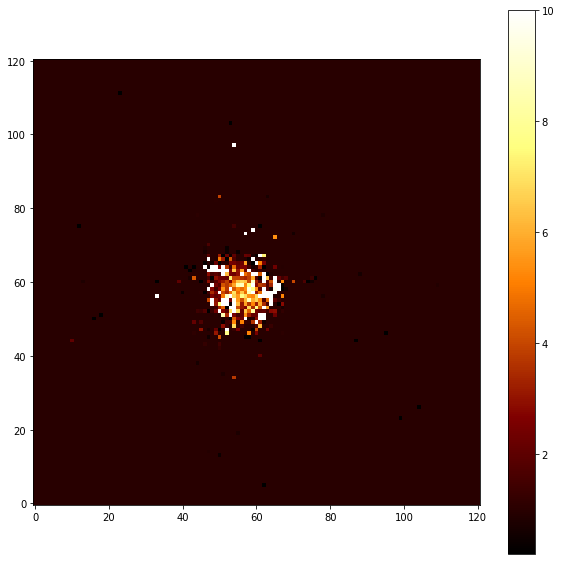

In [16]:
plt.figure(figsize=(10,10))
ratio_core = par[3,:,:]/par[1,:,:]
ratio_wing = par[4,:,:]/par[2,:,:]
plt.imshow(ratio_core,vmin=0.2,vmax=10,origin='lower',cmap='afmhot')  # for SII we can get the electron density from the core. core is extended so high electron density
plt.colorbar()
## NII and Ha ratio gives us the extent of ionization. Ha is not ionized, while NII is. 

In [48]:
# plt.figure(figsize=(10,10))
# smoothed_data_gauss = convolve(ratio_core, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
# plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=0.2,vmax=10)

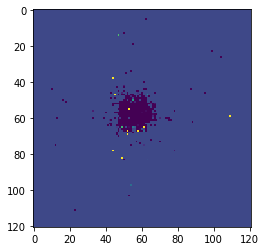

In [17]:
plt.imshow(ratio_wing,vmin=0.45,vmax=3)  # may be a pointlike outflow. If it was extended, we would see high electron density

In [50]:
# def BIC(data,model,n_free_par):
#     N = len(data)
#     BIC=stats.chisquare(data,model)[0] +n_free_par*(np.log(N) - np.log(2*np.pi))
#     return BIC

In [ ]:
# ccd pixels can't resolve faraway objects, so they're convolved. point like emission seems to be spread out. 
# accounting for geometry of imaging system, if we deconvolve to find out actual signal, we can see what the actual structure of 
# the signal. This is the PSF. 

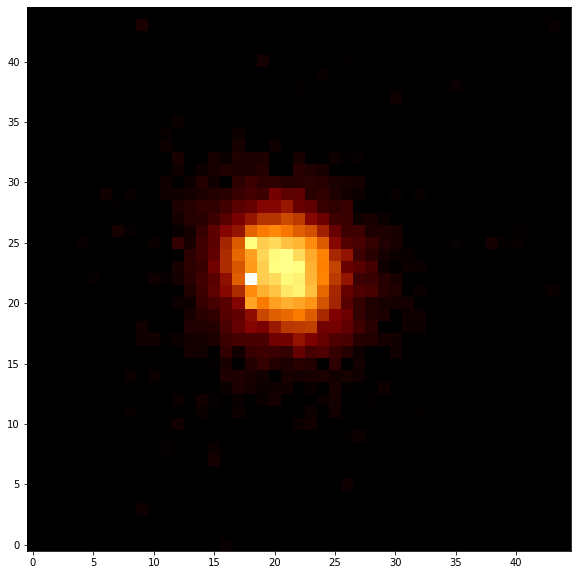

In [3]:
with fits.open('subcube_par_3C264_LSQ_45x45_updated.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Ha = hdu[1].data
    Ha_br = hdu[2].data
    N6583 = hdu[3].data
    N6583_br = hdu[4].data
    S6716 = hdu[5].data
    S6716_br = hdu[6].data
    S6731 = hdu[7].data
    S6731_br = hdu[8].data
    vel_core = hdu[9].data
    vel_core_sigma = hdu[10].data
    vel_wing = hdu[11].data
    vel_wing_sigma = hdu[12].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Ha,cmap='afmhot',origin='lower')

#similar shape to the flux maps, so our analysis was accurate. should look similar but with less SN ratio. fluctuations would be 
#more random. 

In [4]:
fluxDen = np.sum(Ha)
print(fluxDen)

73635.39
